# INFO 621 Project - Team 9 Grape GPU
## Graph-RAG Powered Academic Assistant

The project aims to solve a common challenge in academia: understanding and tracing references in research papers. Our assistant integrates a semantic vector search engine with a citation graph constructed from sources like OpenAlex, enabling:

- Accurate retrieval of relevant research content
- Graph-based contextual expansion using paper citations
- Explainable answers with traceable citation paths

## Application in the notebook

### Installing required packages 

In [ ]:
!pip install -r requirements.txt

### Importing Required Libraries 

In [1]:
import requests
import logging
import simplejson as json
# from langchain_community.utilities import ArxivAPIWrapper
import networkx as nx
import plotly.graph_objects as go
from collections import Counter
from urllib.parse import urlparse
from data_collector import OpenAlexAPI
from matplotlib import pyplot as plt
import numpy as np

from typing import List
from sentence_transformers import SentenceTransformer
from langchain.embeddings.base import Embeddings

from langchain_community.document_loaders import PyPDFDirectoryLoader, PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import chain
from langchain_core.runnables import RunnableLambda, RunnableParallel
from graph_builder import graph_retrieval, build_citation_graph
from operator import itemgetter

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

/Users/gagan/uofa/info_621/project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##  OpenAlex API Wrapper Class 

Impmentation form data_collector.py

In [2]:
class OpenAlexAPI:
    def __init__(self, query):
        
        self.base_url = "https://api.openalex.org/works"
        self.headers = {
            'Accept': 'application/json',
        }
        self.query = query
        self.query_alex_repsone = None
        self.cites = None
        self.citation_url = None

    def get_openalex_id(self, page=1):
        """
        Fetch OpenAlex IDs based on a query.
        """
        params = {
            'search': self.query,
            'page': page,
        }
        response = requests.get(self.base_url, headers=self.headers, params=params)
        
        if response.status_code == 200:
            data = response.json()
            # just return the first response
            if not data['results']:
                logger.warning(f"No results found for query: {self.query}")
                self.query_alex_repsone = None
            self.query_alex_repsone = data['results'][0]
        else:
            logger.error(f"Error fetching OpenAlex IDs: {response.status_code}")
            self.query_alex_repsone = None
            raise Exception(f"Error fetching OpenAlex IDs: {response.status_code}")
    
    def get_citation_url(self):
        """
        Get the citation URL for a given OpenAlex ID.
        """
        if self.query_alex_repsone:
            self.citation_url = self.query_alex_repsone.get('cited_by_api_url', None)

        else:
            logger.warning(f"No OpenAlex ID found for query: {self.query}")
            self.citation_url = None
            raise Exception(f"No OpenAlex ID found for query: {self.query}")

    def query_citation_url(self):
        """
        Fetch citation data from OpenAlex using a citation URL.
        """
        response = requests.get(self.citation_url, headers=self.headers)
        
        if response.status_code == 200:
            data = response.json()
            if data:
                self.cites = data.get('results', [])
        else:
            logger.error(f"Error fetching citation data: {response.status_code}")
            self.cites = None
            raise  Exception(f"Error fetching citation data: {response.status_code}")

    def get_citations(self):
        """
        Fetch citations, related works and references for each one of them for a given OpenAlex ID.
        """
        self.get_openalex_id()
        self.get_citation_url()
        self.query_citation_url()
        
        if self.cites:
            citations = {}
            for cite in self.cites:
                citation_data = {
                    'title': cite.get('title', None),
                    # 'doi': cite.get('doi', None),
                    'openalex_id': cite.get('id', None),
                    'cited_by_count': cite.get('cited_by_count', 0),
                    # 'abstract': cite.get('abstract', None),
                    'publication_year': cite.get('publication_year', None),
                    'related_works': cite.get('related_works', [])[:5],
                    'references': cite.get('referenced_works', [])[:5],
                }
                citations.update({cite.get('id', None): citation_data})
            return { self.query_alex_repsone.get('id', "root"): citations }
            
        else:
            logger.warning(f"No citations found for OpenAlex ID")
            return []


# if __name__ == "__main__":
#     query = "Attention is all you need"
#     openalex_api = OpenAlexAPI(query)
#     _citations = openalex_api.get_citations()

#     with open("citations.json", "w") as _file:
#         json.dump(_citations, _file, indent=4)

In [3]:
query = "Attention is all you need"
openalex_api = OpenAlexAPI(query)
_citations = openalex_api.get_citations()

_citations

{'https://openalex.org/W4385245566': {'https://openalex.org/W3138516171': {'title': 'Swin Transformer: Hierarchical Vision Transformer using Shifted Windows',
   'openalex_id': 'https://openalex.org/W3138516171',
   'cited_by_count': 17865,
   'publication_year': 2021,
   'related_works': ['https://openalex.org/W4390494008',
    'https://openalex.org/W4285411112',
    'https://openalex.org/W3135697610',
    'https://openalex.org/W2922442631',
    'https://openalex.org/W2171299904'],
   'references': ['https://openalex.org/W1522301498',
    'https://openalex.org/W1686810756',
    'https://openalex.org/W1861492603',
    'https://openalex.org/W1901129140',
    'https://openalex.org/W1928278792']},
  'https://openalex.org/W2963420686': {'title': 'Squeeze-and-Excitation Networks',
   'openalex_id': 'https://openalex.org/W2963420686',
   'cited_by_count': 11524,
   'publication_year': 2019,
   'related_works': ['https://openalex.org/W4396701345',
    'https://openalex.org/W4396696052',
    '

## Graph Builder 

Implementation from graph_builder.py

In [4]:

def extract_id(openalex_url):
    """Extract the ID from an OpenAlex URL (e.g., W3159481202 from https://openalex.org/W3159481202)."""
    return urlparse(openalex_url).path.split('/')[-1]

def build_citation_graph_v1(root_id, data, root_title=None):
    """Build a directed citation graph with edges from cited papers to the root paper."""
    G = nx.DiGraph()
    root_id = extract_id(root_id)

    # Step 1: Add root paper node
    root_label = root_title if root_title else f"Paper {root_id}"
    G.add_node(root_id, label=root_label, type='root')

    # Step 2: Add cited papers as nodes
    cited_papers = set(data.keys())
    for pid in cited_papers:
        pid_extracted = extract_id(pid)
        title = data[pid].get('title', f"Paper {pid_extracted}")
        G.add_node(pid_extracted, label=title, type='cited')

    # Step 3: Add edges (from cited papers to root paper)
    edges = []
    for pid in cited_papers:
        pid_extracted = extract_id(pid)
        if pid_extracted != root_id:  # Avoid self-loop if root is in cited papers
            G.add_edge(pid_extracted, root_id)
            edges.append((pid_extracted, root_id))

    print(f"DEBUG: Generated {len(edges)} edges")  # Debugging output
    return G, edges


def build_citation_graph(root_id, data, root_title=None, embedding_model=None):
    """
    Build a directed citation graph with edges from cited papers to root and related works to cited papers.
    Optionally pre-compute node embeddings.
    
    Args:
        root_id: OpenAlex ID of the root paper.
        data: Citation data from OpenAlex (from citations.json).
        root_title: Title of the root paper (optional).
        embedding_model: SentenceTransformer model for embedding node labels (optional).
    
    Returns:
        G: NetworkX DiGraph.
        edges: List of edge tuples.
    """
    G = nx.DiGraph()
    root_id = extract_id(root_id)

    # Step 1: Add root paper node
    root_label = root_title if root_title else f"Paper {root_id}"
    root_attrs = {'label': root_label, 'type': 'root', 'cited_by_count': data.get(root_id, {}).get('cited_by_count', 0)}
    if embedding_model:
        root_attrs['embedding'] = embedding_model.embed_query(root_label).tolist()
    G.add_node(root_id, **root_attrs)

    # Step 2: Add cited papers as nodes
    cited_papers = set(data.keys())
    for pid in cited_papers:
        pid_extracted = extract_id(pid)
        title = data[pid].get('title', f"Paper {pid_extracted}")
        attrs = {
            'label': title,
            'type': 'cited',
            'cited_by_count': data[pid].get('cited_by_count', 0),
            'publication_year': data[pid].get('publication_year', None)
        }
        if embedding_model:
            attrs['embedding'] = embedding_model.embed_query(title).tolist()
        G.add_node(pid_extracted, **attrs)

    # Step 3: Add related works as nodes
    related_works = set()
    for pid in cited_papers:
        for rw in data[pid].get('related_works', []):
            rw_id = extract_id(rw)
            if rw_id not in cited_papers and rw_id != root_id:
                related_works.add(rw_id)
                attrs = {'label': f"Ref {rw_id}", 'type': 'related', 'cited_by_count': 0}
                if embedding_model:
                    attrs['embedding'] = embedding_model.embed_query(attrs['label']).tolist()
                G.add_node(rw_id, **attrs)

    # Step 4: Add edges with weights
    edges = []
    for pid in cited_papers:
        pid_extracted = extract_id(pid)
        if pid_extracted != root_id:
            weight = data[pid].get('cited_by_count', 1) / 100.0  # Normalize weight
            G.add_edge(pid_extracted, root_id, weight=weight)
            edges.append((pid_extracted, root_id))
    for pid in cited_papers:
        pid_extracted = extract_id(pid)
        for rw in data[pid].get('related_works', []):
            rw_id = extract_id(rw)
            if rw_id in related_works:
                G.add_edge(rw_id, pid_extracted, weight=1.0)  # Default weight for related works
                edges.append((rw_id, pid_extracted))

    print(f"DEBUG: Generated {len(edges)} edges (cited→root: {len(cited_papers) - (1 if root_id in [extract_id(p) for p in cited_papers] else 0)}, related→cited: {sum(len(data[pid].get('related_works', [])) for pid in cited_papers)})")
    return G, edges

def graph_retrieval(graph, query_text, top_k=3, max_hops=2, citation_data=None, embedding_model=None):
    """
    Retrieve top-K relevant nodes from the citation graph using semantic similarity and graph metrics.
    
    Args:
        graph: NetworkX DiGraph containing papers and citations.
        query_text: User query string.
        top_k: Number of nodes to return.
        max_hops: Maximum hops for neighbor expansion.
        citation_data: Citation data from OpenAlex (from citations.json) for metadata.
        embedding_model: SentenceTransformer model for embedding query and node labels.
    
    Returns:
        List of dictionaries containing node IDs, attributes, and relevance scores.
    """
    # Embed query
    query_embedding = embedding_model.embed_query(query_text) if embedding_model else None
    node_scores = []
    
    # Score nodes based on semantic similarity and citation count
    for node in graph.nodes(data=True):
        node_id, node_data = node
        label = node_data.get('label', '')
        # Semantic similarity
        if embedding_model and 'embedding' in node_data:
            node_embedding = np.array(node_data['embedding'])
            similarity = np.dot(query_embedding, node_embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(node_embedding))
        else:
            similarity = 1.0 if query_text.lower() in label.lower() else 0.0
        # Citation count (normalized)
        cited_by_count = node_data.get('cited_by_count', 0)
        citation_score = min(cited_by_count / 100, 1.0)  # Cap at 100 citations
        # Combined score
        score = 0.6 * similarity + 0.3 * citation_score
        node_scores.append((node_id, score))
    
    # Select top-K initial nodes
    node_scores = sorted(node_scores, key=lambda x: x[1], reverse=True)
    relevant_nodes = [node_id for node_id, _ in node_scores[:top_k]]
    
    # Expand to neighbors (directed traversal)
    expanded_nodes = set(relevant_nodes)
    hop_distances = {node: 0 for node in relevant_nodes}
    for hop in range(max_hops):
        current_nodes = list(expanded_nodes)
        for node in current_nodes:
            # Follow successors (cited papers) and predecessors (citing papers)
            for neighbor in list(graph.successors(node)) + list(graph.predecessors(node)):
                if neighbor not in expanded_nodes:
                    expanded_nodes.add(neighbor)
                    hop_distances[neighbor] = hop + 1
    
    # Rank expanded nodes
    expanded_papers = []
    for node in expanded_nodes:
        node_data = graph.nodes[node]
        label = node_data.get('label', '')
        # Semantic similarity
        if embedding_model and 'embedding' in node_data:
            node_embedding = np.array(node_data['embedding'])
            similarity = np.dot(query_embedding, node_embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(node_embedding))
        else:
            similarity = 1.0 if query_text.lower() in label.lower() else 0.0
        # Citation count
        cited_by_count = node_data.get('cited_by_count', 0)
        citation_score = min(cited_by_count / 100, 1.0)
        # Hop distance penalty
        hop_distance = hop_distances.get(node, max_hops)
        hop_score = 1.0 - (hop_distance / (max_hops + 1))  # Normalize to 0-1
        # Combined score
        relevance_score = 0.6 * similarity + 0.3 * citation_score + 0.1 * hop_score
        # Enrich with metadata from citation_data
        metadata = {
            'id': node,
            'label': label,
            'type': node_data.get('type'),
            'cited_by_count': cited_by_count,
            'publication_year': node_data.get('publication_year'),
            'relevance_score': relevance_score
        }
        if citation_data and node in citation_data:
            metadata.update({
                'title': citation_data[node].get('title'),
                'publication_year': citation_data[node].get('publication_year')
            })
        expanded_papers.append(metadata)
    
    # Sort by relevance and return top-K
    expanded_papers = sorted(expanded_papers, key=lambda x: x['relevance_score'], reverse=True)
    return expanded_papers[:top_k]



def visualize_static(G, edges):
    """Visualize the graph using Matplotlib with visible edges."""
    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    node_types = nx.get_node_attributes(G, 'type')

    plt.figure(figsize=(12, 8))
    node_colors = ['red' if node_types[n] == 'root' else 'lightblue' for n in G.nodes()]
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=2000, node_color=node_colors,
            font_size=8, font_weight='bold', arrows=True, arrowstyle='->', arrowsize=20)
    plt.title("Static Citation Graph")
    plt.show()

def visualize_interactive(G, edges, root_id):
    """Visualize the graph interactively using Plotly with visible edges."""
    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    node_types = nx.get_node_attributes(G, 'type')

    # Edge traces
    edge_x = []
    edge_y = []
    edge_text = []
    for edge in edges:
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_text.append(f"{edge[0]} → {edge[1]}")

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=3, color='#555'),
        hoverinfo='text',
        text=edge_text[::3],
        mode='lines'
    )

    # Node traces
    node_x = []
    node_y = []
    node_text = []
    node_colors = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(labels[node])
        node_colors.append('red' if node == root_id else 'lightblue')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition='top center',
        hoverinfo='text',
        marker=dict(size=20, color=node_colors, line=dict(width=2))
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Interactive Citation Graph',
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))

    # fig.show()
    return fig

def main(root_id, data, root_title=None):
    """Main function to build and visualize the citation graph."""
    G, edges = build_citation_graph(root_id, data, root_title)
    
    # Print nodes and edges
    print("Nodes:")
    for node, attr in G.nodes(data=True):
        print(f"- {node}: {attr['label']} ({attr['type']})")
    print("\nEdges:")
    if not edges:
        print("No edges found in the graph.")
    for citing, cited in edges:
        print(f"- {citing} → {cited}")
    
    # Visualize the graph
    visualize_static(G, edges)
    fig = visualize_interactive(G, edges, extract_id(root_id))
    fig.show()


# if __name__ == "__main__":

#     # paper = "Attention is all you need"
#     # openalex_api = OpenAlexAPI(paper)
#     # data = openalex_api.get_citations()
#     import simplejson as json
#     with open("citations.json", "r") as _file:
#         data = json.load(_file)
#     # main(
#     #     root_id=openalex_api.query,
#     #     data=data[openalex_api.query_alex_repsone.get('id', "root")],
#     #     root_title=paper
#     # )

#     main(
#         root_id=list(data.keys())[0],
#         data=data[list(data.keys())[0]],
#         root_title="Attention is all you need"
#     )

DEBUG: Generated 275 edges (cited→root: 25, related→cited: 250)
Nodes:
- W4385245566: Attention is all you need (root)
- W2963091558: Non-local Neural Networks (cited)
- W2963420686: Squeeze-and-Excitation Networks (cited)
- W3035390927: Unsupervised Cross-lingual Representation Learning at Scale (cited)
- W4312933868: High-Resolution Image Synthesis with Latent Diffusion Models (cited)
- W2933138175: fairseq: A Fast, Extensible Toolkit for Sequence Modeling (cited)
- W3034999214: BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension (cited)
- W2970641574: Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks (cited)
- W4313156423: Masked Autoencoders Are Scalable Vision Learners (cited)
- W3177318507: Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting (cited)
- W3170841864: Rethinking Semantic Segmentation from a Sequence-to-Sequence Perspective with Transformers (cited)
- W2979826702: T

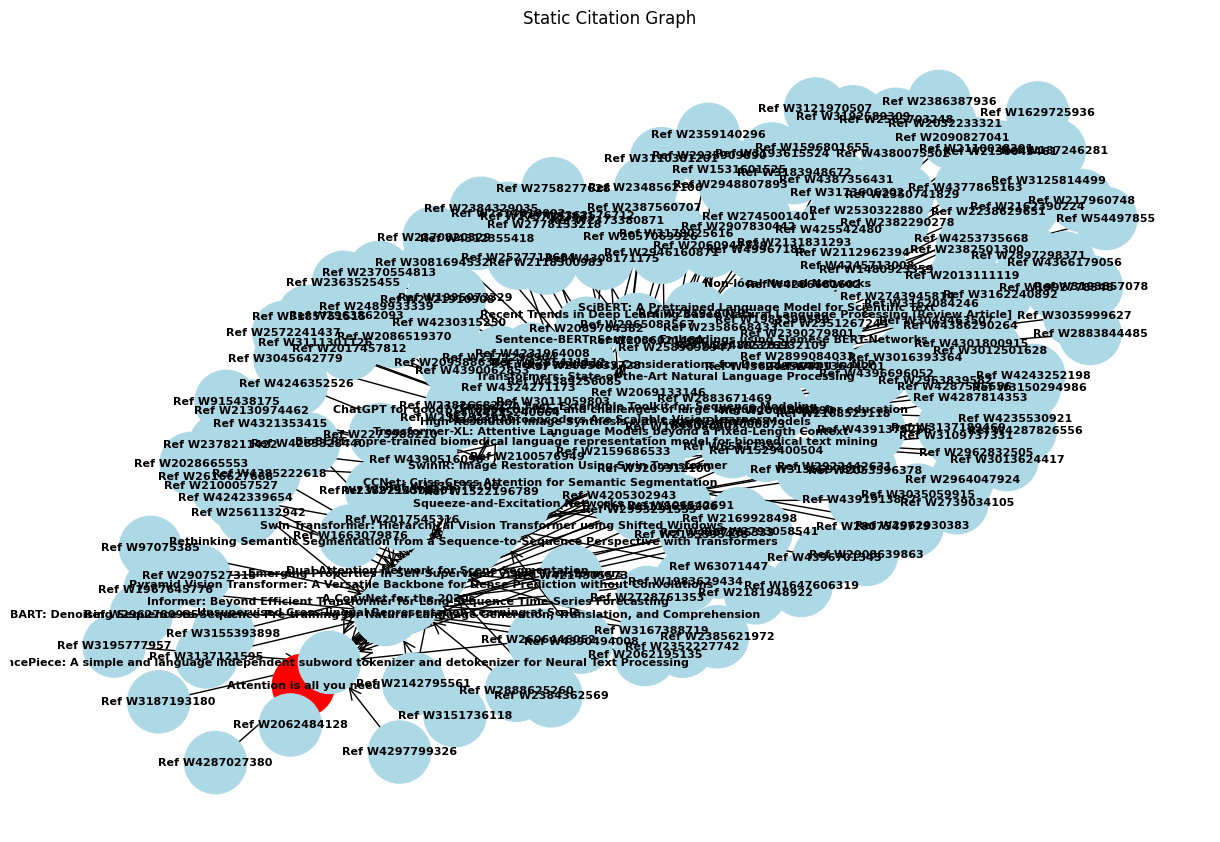

In [5]:
with open("citations.json", "r") as _file:
    data = json.load(_file)
main(
    root_id=list(data.keys())[0],
    data=data[list(data.keys())[0]],
    root_title="Attention is all you need"
)

## Enabling Tracing (optional)



```bash
docker pull arizephoenix/phoenix
docker run -p 6006:6006 -p 4317:4317 -i -t arizephoenix/phoenix:latest

```

In [8]:
try:
    import os
    os.environ["PHOENIX_COLLECTOR_ENDPOINT"] = "http://localhost:6006"
    from phoenix.otel import register
        # configure the Phoenix tracer
    tracer_provider = register(
        project_name="my-llm-app", # Default is 'default'
        auto_instrument=True # Auto-instrument your app based on installed OI dependencies
    )
    print("INFO: Tracing enabled.")
except Exception as e:
    print(f"WARNING: Not able to enable Tracing: {e}")
    # Handle the error or log it as needed

INFO:phoenix.config:📋 Ensuring phoenix working directory: /Users/gagan/.phoenix
INFO:phoenix.inferences.inferences:Dataset: phoenix_inferences_c6ea712f-ce03-426a-b30a-6e4173ee4b5e initialized


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: my-llm-app
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.

INFO: Tracing enabled.


## RAG - Vector DB and Graph Retrival

Host the model before running this part.

#### Running a model using ollama
```bash 
docker run -d -v ollama:/root/.ollama -p 11434:11434 --name ollama ollama/ollama      
docker exec -it ollama ollama run llama3.2:3b
```


In [9]:

# from langchain_openai import OpenAI
# from langchain.chat_models import init_chat_model
# from langchain_openai import OpenAIEmbeddings

# embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# from langchain_openai import OpenAI
from langchain_ollama import ChatOllama
import getpass
import os
import simplejson as json
import numpy as np
import warnings

clean_title = lambda x : x.split("#")[2].strip()

from langchain_docling import DoclingLoader
from langchain_docling.loader import ExportType

# Suppress the specific tokenizer warning
warnings.filterwarnings("ignore", category=FutureWarning, 
                       message="`clean_up_tokenization_spaces` was not set")


class CustomEmbeddings(Embeddings): 
    def __init__(self, model_name: str):
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, documents: List[str]) -> List[List[float]]:
        return [self.model.encode(d).tolist() for d in documents]

    def embed_query(self, query: str) -> List[float]:
        return self.model.encode([query])[0].tolist()


class PDFQuestionAnswering:
    def __init__(self, chunk_size: int = 300, chunk_overlap: int = 200):
        # Initialize OpenAI LLM

        self.llm = ChatOllama(model="llama3.2:3b", temperature=0.1)

        # Initialize embedding model
        self.embedding_model = CustomEmbeddings(model_name="all-MiniLM-L6-v2")
        # self.embedding_model = embeddings
        
        # Initialize text splitter
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            add_start_index=True,
            # length_function=len
        )
        
        # Initialize empty vectorstore
        self.vectorstore = Chroma(
            embedding_function=self.embedding_model,
            persist_directory="chroma",
            collection_name="pdf_qa",
        )
        
        # Setup QA chain
        self.qa_chain = self._setup_qa_chain()
        with open("citations.json", "r") as _file:
            self.citation_data = json.load(_file)
        root_id = list(self.citation_data.keys())[0]
        self.G, _ = build_citation_graph(root_id, self.citation_data[root_id], root_title="Attention is All You Need")


    def load_documents_from_dir(self, directory: str):
        # Load documents from the specified directory
        document_loader = PyPDFDirectoryLoader(directory)
        documents = document_loader.load()
        processed_files_for_titles = set() # To avoid processing title for every page of the same file

        print("\n--- Extracted Titles from Directory ---")
        for doc in documents:
            source_file = doc.metadata.get('source')
            if source_file and source_file not in processed_files_for_titles:
                title = doc.metadata.get('title')
                base_filename = os.path.basename(source_file)
                if title:
                    print(f"File: {base_filename}, Title (from metadata): {title}")
                    self.extracted_titles[base_filename] = title
                else:
                    # Fallback: use filename (without extension) if title metadata is missing
                    filename_title = os.path.splitext(base_filename)[0].replace('_', ' ').replace('-', ' ')
                    print(f"File: {base_filename}, Title (from filename): {filename_title}")
                    self.extracted_titles[base_filename] = filename_title
                processed_files_for_titles.add(source_file)
        if not documents:
            print("No PDF documents found or loaded from the directory.")
        print("-------------------------------------\n")
        
        return documents

    def load_document(self, file_path: str):

        # title = extract_title_from_pdf(file_path)
        l = DoclingLoader(file_path, export_type=ExportType.MARKDOWN).load()

        # print(f"Extracted title: {}")
        title = clean_title(l[0].page_content.split("\n")[0])
        print("+==========================")
        print( "TITLE : ", title)
        print("+==========================")

        # document_loader = PyPDFLoader(file_path, extract_images=False)


        # documents = document_loader.load()
        # metadata={"title" : }

        for doc in l:
            doc.metadata.update({"title": title})

        # return documents
        return l

    def add_documents(self, documents, metadata={}):
        print(documents[0].metadata)
        if documents:
            # Split documents into chunks
            chunks = self.text_splitter.split_documents(documents)
            # Add chunks to vectorstore
            self.vectorstore.add_documents(chunks)
        else:
            raise Exception("No documents to add.")

    def ask_question_v1(self, question: str) -> str:
        # Ask a question and get the answer
        if not self.vectorstore:
            raise Exception("No documents in the vectorstore.")
        
        response = self.qa_chain.invoke({"question": question})
        return response

    def ask_question(self, question: str):
        if not self.vectorstore:
            raise Exception("No documents in the vectorstore.")
        
        # Get vector and graph results
        retriever = self.vectorstore.as_retriever(search_kwargs={"k": 5})
        vector_results = self.vectorstore.similarity_search_with_score(question, k=5)
        # Convert to expected format for fusion
        vector_results_formatted = {
            'documents': [[doc.page_content for doc, _ in vector_results]],
            'metadatas': [[doc.metadata for doc, _ in vector_results]],
            'distances': [[score for _, score in vector_results]]
        }
        query_embedding = self.embedding_model.embed_query(question)
        # self.G , edges = build_citation_graph(list(data.keys())[0], data[list(data.keys())[0]], root_title)
        graph_results = graph_retrieval(self.G, question, top_k=3, max_hops=2, embedding_model=self.embedding_model)
        
        # Fuse results
        fused_results = self.fuse_and_rank_results(vector_results_formatted, graph_results, query_embedding, top_n=5)
        
        # Prepare context for LLM
        context = "\n\n".join([res["content"] for res in fused_results])
        citation_path = [res["metadata"].get("title", res["content"].replace("Title: ", "")) 
                         for res in fused_results if res["source"] == "citation_graph"]
        
        # Generate answer
        response = self.qa_chain.invoke({"question": question, "context": context})
        
        # Compute confidence
        vector_scores = [res["relevance_score"] for res in fused_results if res["source"] == "vector_db"]
        graph_scores = [res["relevance_score"] for res in fused_results if res["source"] == "citation_graph"]
        avg_vector_score = np.mean(vector_scores) if vector_scores else 1
        avg_graph_score = np.mean(graph_scores) if graph_scores else 1
        confidence = 0.6 * avg_vector_score + 0.4 * avg_graph_score
        
        # Structure response
        return {
            "answer": response,
            "explanation": {
                "retrieved_chunks": [
                    {"content": res["content"], "metadata": res["metadata"]}
                    for res in fused_results if res["source"] == "vector_db"
                ],
                "citation_path": citation_path,
                "confidence": round(confidence, 2)
            }
        }


    def fuse_and_rank_results(self, vector_results, graph_results, query_embedding, top_n=5):
        fused_results = []
        # Process vector results
        for i in range(len(vector_results['documents'][0])):
            distance = vector_results['distances'][0][i]
            relevance_score = 1 - distance  # Convert cosine distance to similarity (0-1)
            fused_results.append({
                "source": "vector_db",
                "content": vector_results['documents'][0][i],
                "metadata": vector_results['metadatas'][0][i],
                "relevance_score": relevance_score
            })
        # Process graph results
        for paper in graph_results:
            # Compute semantic similarity between query and node label
            label = paper.get('label', '')
            label_embedding = self.embedding_model.embed_query(label)
            similarity = np.dot(query_embedding, label_embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(label_embedding))
            # Add citation count as a factor (normalize to 0-1)
            cited_by_count = self.citation_data.get(paper['id'], {}).get('cited_by_count', 0)
            citation_score = min(cited_by_count / 100, 1.0)  # Cap at 100 citations
            # Combine scores (weighted)
            relevance_score = 0.7 * similarity + 0.3 * citation_score
            fused_results.append({
                "source": "citation_graph",
                "content": f"Title: {label}",
                "metadata": {"openalex_id": paper.get('id'), "type": paper.get('type')},
                "relevance_score": relevance_score
            })
        # Rank and select top-N
        ranked_results = sorted(fused_results, key=lambda x: x['relevance_score'], reverse=True)
        return ranked_results[:top_n]

    def _setup_qa_chain(self, root_title="Attention is All You Need"):
        prompt = ChatPromptTemplate.from_messages([
            ("system", ("You are an assistant for question-answering tasks. "
                        "Use the following pieces of retrieved context to answer "
                        "the question. If you don't know the answer, say that you "
                        "don't know. Use three sentences maximum and keep the "
                        "answer concise."
                        "\n\n"
                        "<context>"
                        "{context}"
                        "</context>")),
            ("human", "{question}")
        ])
        
        chain = (
            {"context": lambda x: x["context"], "question": lambda x: x["question"]}
            | prompt
            | self.llm
            | StrOutputParser()
        )
        return chain

# if __name__ == "__main__":
#     # if not os.environ.get("OPENAI_API_KEY"):
#     #     os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")
#     # _E = CustomEmbeddings(model_name="all-MiniLM-L6-v2")


#     # Example usage
#     pdf_qa = PDFQuestionAnswering(chunk_size=3000, chunk_overlap=0)
    
#     # Load documents from a directory
#     # documents = pdf_qa.load_documents_from_dir("./papers")
    
#     # Load each pdf file separately
#     # if not os.path.exists("./chroma"):
#     papers_dir = "./papers"
#     import glob
#     pdf_files = glob.glob(os.path.join(papers_dir, "*.pdf"))
#     for document in pdf_files:
#         print(f"Processing file: {document}")
#         print("==========================")
#         # print(f"Loading document: {document}")
#         documents= pdf_qa.load_document(document)
#         # Add documents to the vectorstore

#         pdf_qa.add_documents(documents)
        
#     question = input("Enter your question: ")
#     # Ask a question
#     answer = pdf_qa.ask_question(question)
#     print(answer)

#     # question = input("Enter your question: ")
#     # answer = pdf_qa.ask_question(question)
#     print("Answer:", answer["answer"])
#     print("\nExplanation:")
#     print("Retrieved Chunks:")
#     for chunk in answer["explanation"]["retrieved_chunks"]:
#         print(f"- {chunk['content']} (Metadata: {chunk['metadata']})")
#     print("Citation Path:", " → ".join(answer["explanation"]["citation_path"]))
#     print(f"Confidence: {answer['explanation']['confidence']}")

Documents are already indexed in ./chroma directory, so we can just query them 

In [10]:
pdf_qa = PDFQuestionAnswering(chunk_size=3000, chunk_overlap=0)
question = input("Enter your question: ")
print("Query : ", question)
answer = pdf_qa.ask_question(question)
print("Answer:", answer["answer"])
print("\nExplanation:")
print("Retrieved Chunks:")
for chunk in answer["explanation"]["retrieved_chunks"]:
    print(f"- {chunk['content']} (Metadata: {chunk['metadata']})")
print("Citation Path:", " → ".join(answer["explanation"]["citation_path"]))
print(f"Confidence: {answer['explanation']['confidence']}")

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


DEBUG: Generated 275 edges (cited→root: 25, related→cited: 250)
Query :  What is attention ?


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.49it/s]
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Answer: Attention is a mechanism in deep learning that allows a model to focus on specific parts of the input data when making predictions or decisions. It helps the model to selectively weigh the importance of different features or regions in the input data, and to ignore irrelevant information. In essence, attention enables the model to "look" at the most relevant parts of the input data and use them to make a prediction.

Explanation:
Retrieved Chunks:
- - [46] B. A. Olshausen, C. H. Anderson, and D. C. V. Essen, 'A neurobiological model of visual attention and invariant pattern recognition based on dynamic routing of information,' Journal of Neuroscience , 1993.
- [47] L. Itti, C. Koch, and E. Niebur, 'A model of saliency-based visual attention for rapid scene analysis,' IEEE Transactions on Pattern Analysis and Machine Intelligence , 1998.
- [48] L. Itti and C. Koch, 'Computational modelling of visual attention,' Nature reviews neuroscience , 2001.
- [49] H. Larochelle and G. E. H

![alt text](<./docs/traces.png>) ![alt text](<./docs/traceoutput.png>)